# JPEG compression regressor


In this little project, the aim is to regress whether and at what extent an image has been JPEG
compressed. JPEG compression uses discrete cosine transform to quantize higher frequencies in 8x8 windows.


This project tends to use frequency domain to analyze whether an image has been compressed. A RandomForestRegressor
is trained on eingenvalues from mean spectrum of all 8x8 patches from an image. 

To ensure space robustness,
eigenvalues are extracted also from shifted patches.


### NOTE
It is indeed possible to use approaches found in literature, but I found this task can be taken from a custom
and more fun perspective.

In [9]:
from typing import Tuple

import cv2
import einops
from matplotlib import pyplot as plt
import numpy as np
import torch
from torchvision.io import encode_jpeg, read_image, write_png, ImageReadMode


class SplitPatch:
    
    def __init__(self, window_size: Tuple[int, int]):
        self.window_size = window_size
        
    def __call__(self, image):
        return einops.rearrange(image, "c (h i) (w k) -> (h w c) i k", i=self.window_size[0], k=self.window_size[1])


def simulate_jpeg_compression(image: np.ndarray, jpeg_quality: int = 100) -> np.ndarray:
    compressed_image = image.copy()
    *_, encoded = cv2.imencode(".jpg", compressed_image, [cv2.IMWRITE_JPEG_QUALITY, jpeg_quality])
    return cv2.imdecode(encoded, 1)


def fourier_transform_method(splitter, image):
    fft = torch.fft.fft2(splitter(image))
    fft = torch.abs(fft)
    return fft


def extract_features(fft):
    return torch.abs(torch.linalg.eigvals(fft)).mean(0).numpy()


def process_image(image):
    splitter = SplitPatch((8, 8))
    return extract_features(fourier_transform_method(splitter, image))


def process_image_with_shift(image):
    feats = []

    for shift in range(8):
        splitter = SplitPatch((8, 8))
        feats.append(extract_features(fourier_transform_method(
            splitter, torch.roll(image, shifts=(-shift, -shift), dims=(-1, -2)))))
    return torch.from_numpy(np.array(feats)).flatten()


def pca(tensor, n_components=3):
    assert tensor.shape[1] < tensor.shape[0]
    cov_mat = torch.matmul(tensor.transpose(0, 1), tensor) / (tensor.shape[0] - 1)
    eigen = torch.eig(cov_mat, eigenvectors=True)
    return torch.matmul(tensor, eigen[1][:, :n_components])


## Example of image + its patch eigenvalues sum (in frequency domain)

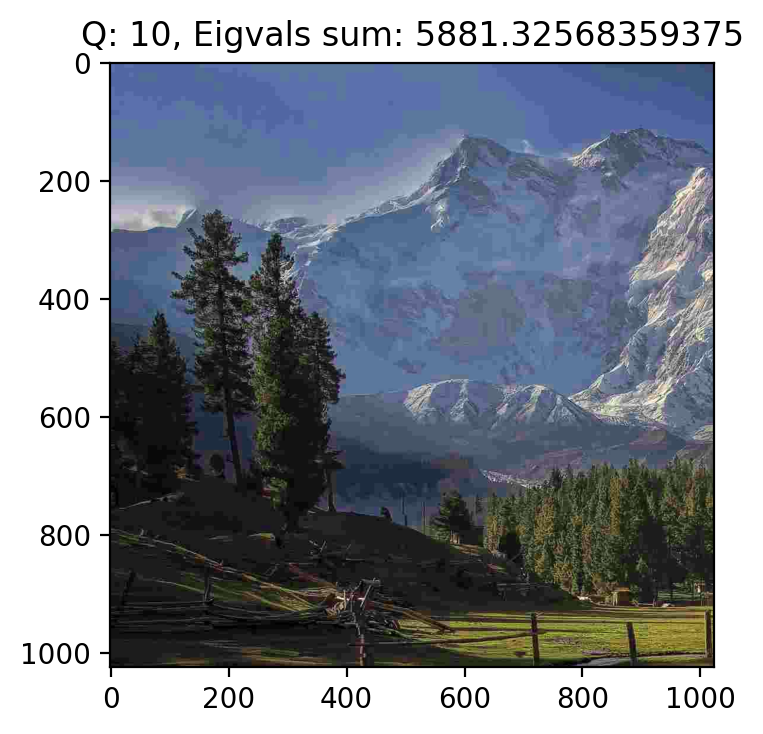

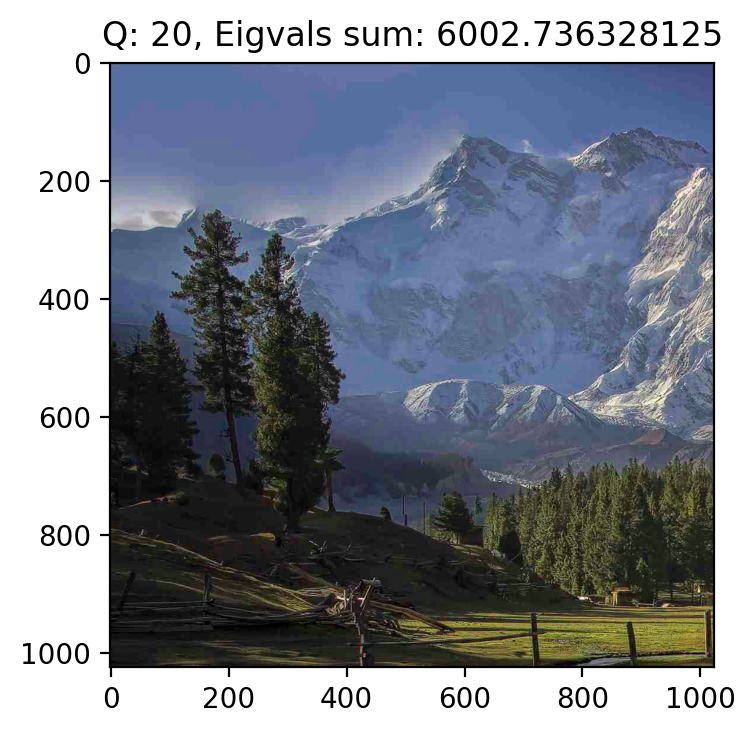

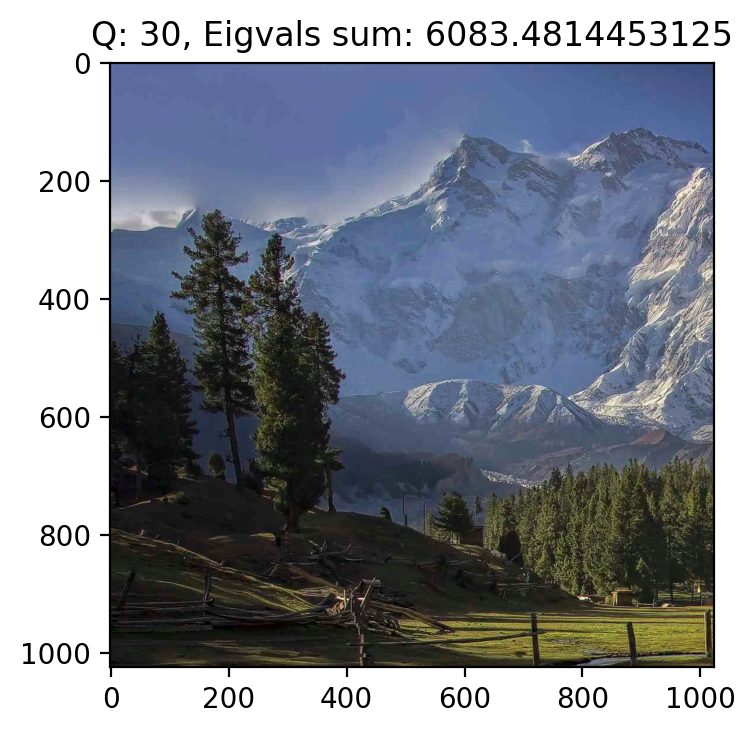

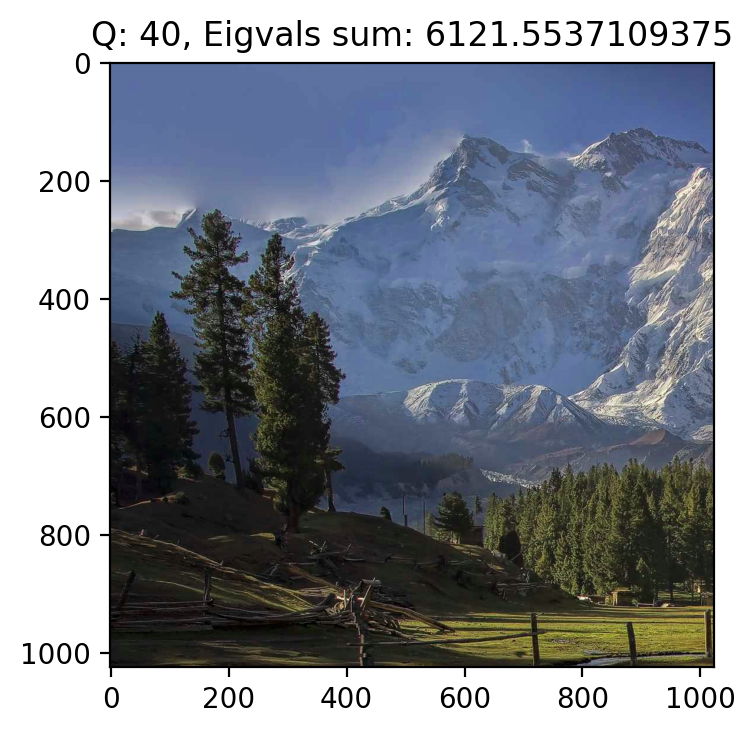

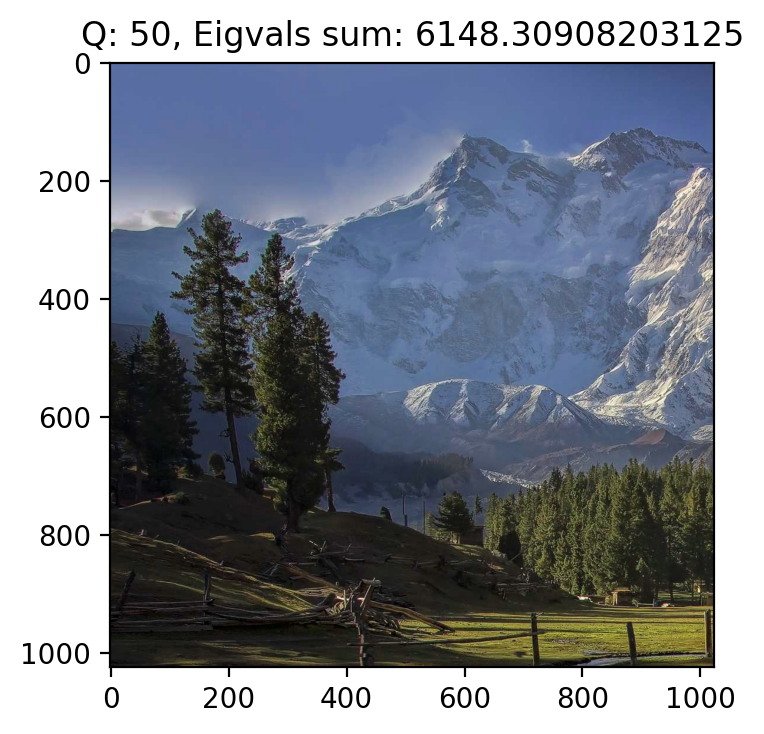

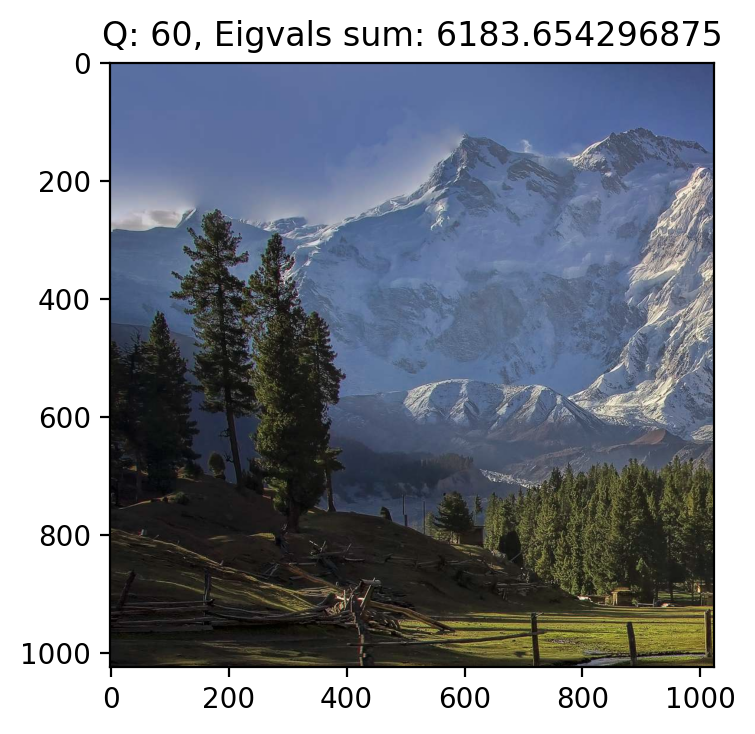

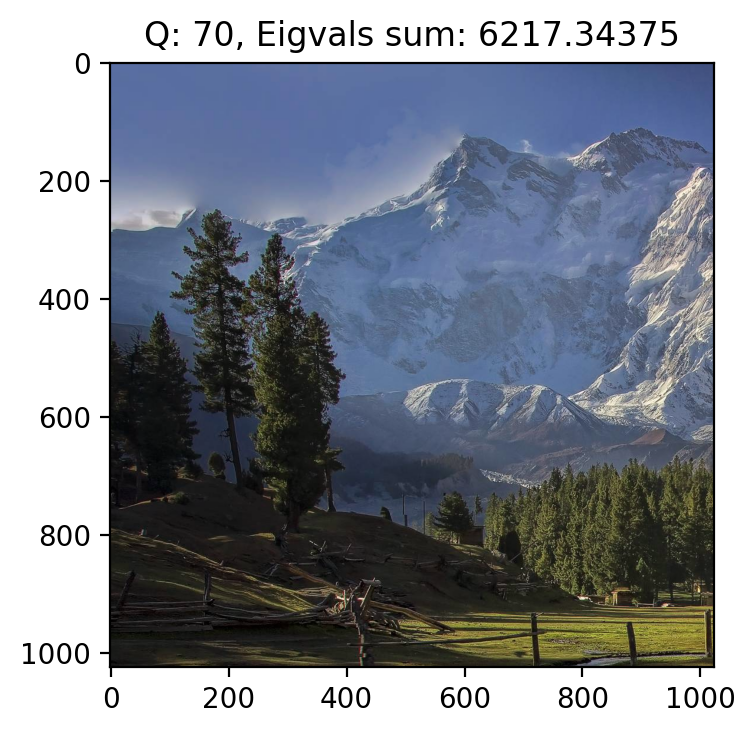

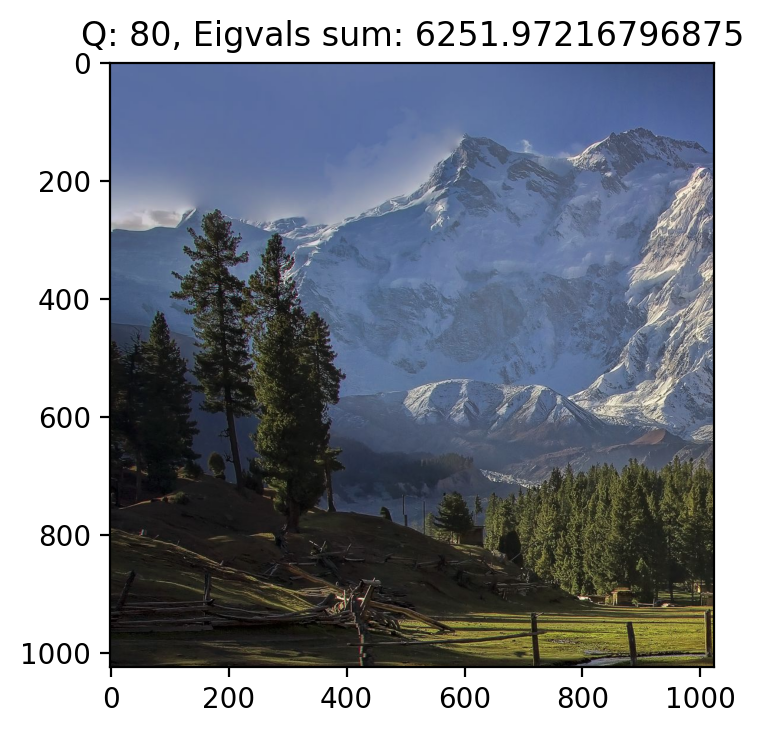

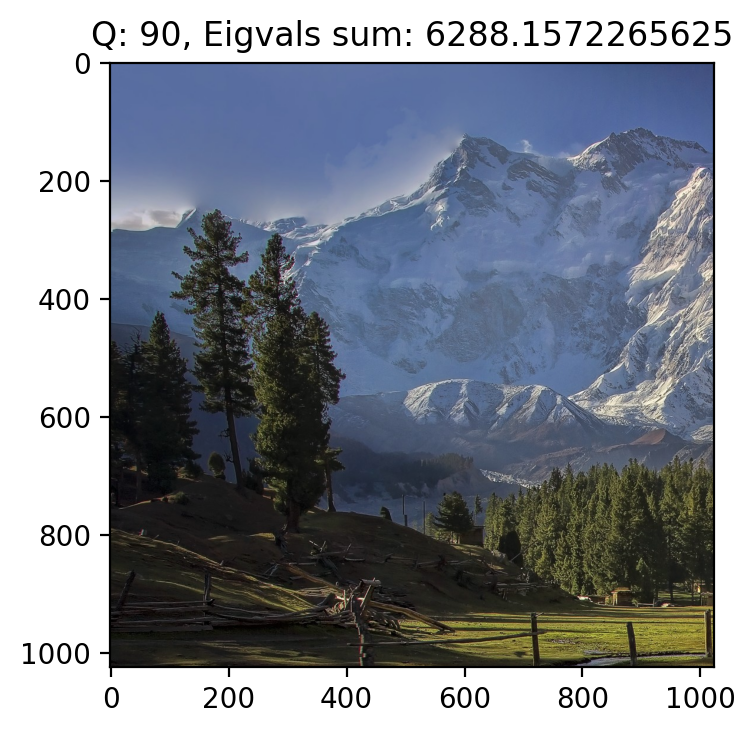

In [18]:
values = []
image = read_image("./data/val_dataset/0002.png", mode=ImageReadMode.RGB)[:, :1024, :1024]
for quality in range(10, 100, 10):
    compressed_image = torch.from_numpy(simulate_jpeg_compression(image.permute(1, 2, 0).numpy(), jpeg_quality=quality)).permute(2, 0, 1)
    write_png(compressed_image, "a.png")
    fourier = fourier_transform_method(SplitPatch((8, 8)), image)
    compressed_fourier = fourier_transform_method(SplitPatch((8, 8)), compressed_image)
    values.append((compressed_image, f"Q: {quality}, Eigvals sum: {np.sum(extract_features(compressed_fourier))}"))

    
for idx, value in enumerate(values):
    plt.figure(dpi=200)
    plt.imshow(value[0].permute(1, 2, 0).numpy())
    plt.title(value[1])
    plt.show()

In [10]:
from collections import namedtuple
import glob
import os
import random
from typing import Callable, Union

import cv2
import torch
import torch.utils.data as data


RandomMinMax = namedtuple("RandomMinMax", ["min", "max"])


class SimpleClassificationDataset(data.Dataset):
    
    def __init__(self, image_folder, transforms: Callable, compression_probability: float = 0.8, 
                 jpeg_quality: RandomMinMax = RandomMinMax(min=20, max=95), image_shape: Union[None, Tuple] = None):
        self.images = glob.glob(os.path.join(image_folder, "*"))
        self.transforms = transforms
        self.compression_probability = compression_probability
        self.jpeg_quality = jpeg_quality
        self.image_shape = image_shape
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        image = cv2.imread(self.images[item])
        if self.image_shape is not None:
            image = cv2.resize(image, self.image_shape, interpolation=cv2.INTER_LINEAR)
        if is_compression := (random.random() < self.compression_probability):
            compression_level = random.randint(self.jpeg_quality.min, self.jpeg_quality.max)
            image = simulate_jpeg_compression(image, jpeg_quality=compression_level)
        else:
            compression_level = 100
        image = self.transforms(image)
        return torch.from_numpy(image).float().permute(2, 0, 1), torch.tensor([is_compression]).long(), torch.tensor([compression_level]).float(), self.images[item]

## Train simple RandomForestRegressor from sklearn

In [11]:
from typing import Callable, Iterable

from sklearn.ensemble import RandomForestRegressor


def create_dataset(dataset: Iterable, extraction_function: Callable, features_length: int = 8):
    
    feats = np.zeros((len(dataset), features_length))
    targets = np.zeros((len(dataset)))
    
    for idx, (image, is_compressed, compression_level, path) in enumerate(dataset):
        features = extraction_function(image)
        feats[idx, :] = features
        targets[idx] = compression_level
    
    return feats, targets

dataset = SimpleClassificationDataset("./data/DIV2K_train_HR", lambda x: x, image_shape=(1024, 1024))
samples, targets = create_dataset(
    dataset, 
    process_image, 
    8)
regressor = RandomForestRegressor(n_estimators=20)
regressor.fit(samples, targets)

RandomForestRegressor(n_estimators=20)

## Simple check

In [12]:
import pandas as pd

checks = {"GT": [], "PRED": []}

for idx in range(25):
    sample = dataset[idx]
    features = process_image(sample[0])
    pred = regressor.predict(np.expand_dims(features, axis=0))
    checks["GT"].append(sample[2])
    checks["PRED"].append(pred)
    
pd.DataFrame.from_dict(checks)

GT     PRED
0    [tensor(64.)]   [68.2]
1    [tensor(72.)]  [69.25]
2    [tensor(62.)]  [49.65]
3    [tensor(87.)]   [94.2]
4    [tensor(82.)]  [88.95]
5   [tensor(100.)]  [100.0]
6    [tensor(62.)]   [66.8]
7    [tensor(82.)]  [76.75]
8    [tensor(22.)]  [25.65]
9    [tensor(66.)]   [57.5]
10   [tensor(91.)]   [85.5]
11   [tensor(56.)]   [55.1]
12   [tensor(44.)]   [38.4]
13   [tensor(42.)]  [35.95]
14   [tensor(84.)]  [92.35]
15   [tensor(57.)]  [62.75]
16   [tensor(39.)]  [39.05]
17   [tensor(53.)]  [53.45]
18   [tensor(22.)]  [48.35]
19   [tensor(34.)]   [41.6]
20   [tensor(26.)]  [47.35]
21   [tensor(42.)]  [40.95]
22   [tensor(51.)]   [42.4]
23   [tensor(93.)]   [89.6]
24   [tensor(91.)]  [88.75]

## Inference

Validation test inference and storing it under pandas dataframe.

In [13]:
import os
from typing import Iterable, Callable

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm


def infer_images(regressor: RandomForestRegressor, dataset: Iterable, extraction_function: Callable) -> pd.DataFrame:
    output_dict = {
        "image": [],
        "compression_prediction": []
    }
    for idx in tqdm(range(len(dataset))):
        sample = dataset[idx]
        features = extraction_function(sample[0])
        pred = regressor.predict(np.expand_dims(features, axis=0))
        output_dict["image"].append(os.path.basename(sample[3]))
        output_dict["compression_prediction"].append(pred[0])
    return pd.DataFrame.from_dict(output_dict)


dataset_inference = SimpleClassificationDataset("./data/val_dataset/", lambda x: x, image_shape=(1024, 1024), compression_probability=-1.)
prediction_frame = infer_images(regressor, dataset_inference, process_image)
prediction_frame

  0%|          | 0/34 [00:00<?, ?it/s]

image  compression_prediction
0                                  00001_50_70_90.jpg                   48.30
1                             img_20220110_134535.png                   95.35
2              8725893_PhotoCollage_1585735486638.jpg                  100.00
3                                   low_90_killed.jpg                   82.30
4                                        00001_45.png                   60.55
5                                      web_low_90.jpg                   70.45
6                               Ref_Image_low res.jpg                   81.00
7                                         0810_80.jpg                   99.20
8                               8873192_199471515.jpg                   90.05
9                              look.com.ua-267301.jpg                   94.35
10                                           ppt3.png                   64.90
11                             film-grain-overlay.jpg                   95.00
12                                     desantnica.png                   69.40
13                               low_60_90_killed.jpg                   69.25
14  olga-boyko-a-warrior-devushka-krasotka-rytsar-...                  100.00
15                                         region.png                   48.90
16                                         slonik.jpg                   75.05
17                                            q52.png                   69.55
18                                        0810_20.jpg                   54.90
19                                           0002.png                   98.95
20  8782597_1F9DC2C3-A67E-4379-A1A6-A0228F939355.jpeg                   87.30
21                              9014255_hoka-mach.png                   91.70
22                                          indus.png                   68.10
23                                              1.jpg                   65.00
24                            IMG_20220110_133943.png                   97.70
25                                     image (14).png                   50.00
26                                       00001_20.jpg                   55.95
27          8828824_BodyEditor_20200329_162131317.jpg                   72.05
28                            img_20220107_145854.png                  100.00
29                                         low_60.jpg                   64.55
30               1e8b970f4259424bcf6c79903bb46a41.jpg                   75.05
31                                         low_80.jpg                   45.55
32  8732539_lislleyavila_2020_04_01_05_58_22_CLIQU...                   61.85
33                                        region2.png                   45.90

# Approach using neural networks

In this part, Convolutional network is used. Transformer could be used as well, but we think that
convolution may be well suited for this type of task.

Why? Because according to Convolution theorem, convolution is directly assotiated with spectrum and vice versa.

In [25]:
import torch
import torch.utils.data as data
import torchvision.models as models
from tqdm.notebook import tqdm


class CompressionRegressionTrainer:
    
    def __init__(self):
        self.device = "cuda"
        self.model = self._get_small_model().to(self.device)
        dataset = SimpleClassificationDataset("./data/DIV2K_train_HR", lambda x: x, image_shape=(1024, 1024))
        split_ratio = 0.8
        train, val = data.random_split(dataset, (int(len(dataset) * split_ratio) + 1, int(len(dataset) * (1 - split_ratio))))
        self.train_loader = data.DataLoader(
            train, batch_size=4, num_workers=4, shuffle=True
        )
        self.val_loader = data.DataLoader(
            val, batch_size=4, num_workers=4, shuffle=False
        )
        self.loss = torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-4, weight_decay=1e-4)
        
    def _get_small_model(self):
        model = models.mobilenet_v3_small(pretrained=True)
        model.classifier = torch.nn.Sequential(*[
            torch.nn.Linear(576, 1),
            torch.nn.Sigmoid()
        ])
        return model
    
    def train(self, num_epochs):
        for epoch in range(num_epochs):
            self.train_epoch(epoch)
            self.validate_epoch(epoch)
        return torch.jit.script(self.model)

    def train_epoch(self, epoch):
        self.model.train()
        
        loader = tqdm(self.train_loader)
        for idx, data in enumerate(loader):
            self.optimizer.zero_grad()
            image, is_compression, label, path = data
            label = label / 100.
            image, label = [d.to(self.device) for d in [image, label]]
            output = self.model(image)
            loss = self.loss(output, label)
            loss.backward()
            self.optimizer.step()
            loader.set_description(f"EPOCH: {epoch}, loss: {loss.item()}, compression: {output.tolist()}, label: {label.tolist()}")
    
    @torch.no_grad()
    def validate_epoch(self, epoch):
        self.model.eval()

        loader = tqdm(self.train_loader)
        for idx, data in enumerate(loader):
            image, is_compression, label, path = data
            label = label / 100.
            image, label = [d.to(self.device) for d in [image, label]]
            output = self.model(image)
            loss = self.loss(output, label)
            loader.set_description(f"EPOCH: {epoch}, loss: {loss.item()}, compression: {output.tolist()}, label: {label.tolist()}")
        

model = CompressionRegressionTrainer().train(5)
model.save("compression_model.pt")

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

In [8]:
import pandas as pd
from tqdm.notebook import tqdm


dataset_inference = SimpleClassificationDataset("./data/val_dataset/", lambda x: x, image_shape=(1024, 1024), compression_probability=-1.)
model = torch.jit.load("compression_model.pt")


output_dict = {
        "image": [],
        "compression_prediction": []
    }
for idx in tqdm(range(len(dataset_inference))):
    sample = dataset_inference[idx]
    with torch.no_grad():
        pred = model(sample[0].to("cuda").unsqueeze(0))
    output_dict["image"].append(os.path.basename(sample[3]))
    output_dict["compression_prediction"].append(float(pred[0].cpu()) * 100)

pd.DataFrame.from_dict(output_dict)
 

  0%|          | 0/34 [00:00<?, ?it/s]

image  compression_prediction
0                                  00001_50_70_90.jpg               43.673870
1                             img_20220110_134535.png               91.214967
2              8725893_PhotoCollage_1585735486638.jpg               92.210907
3                                   low_90_killed.jpg               95.801562
4                                        00001_45.png               43.082458
5                                      web_low_90.jpg               92.444181
6                               Ref_Image_low res.jpg               61.043733
7                                         0810_80.jpg               88.001323
8                               8873192_199471515.jpg               67.108393
9                              look.com.ua-267301.jpg               78.565192
10                                           ppt3.png               61.149603
11                             film-grain-overlay.jpg               95.632797
12                                     desantnica.png               55.041158
13                               low_60_90_killed.jpg               62.410206
14  olga-boyko-a-warrior-devushka-krasotka-rytsar-...               74.861312
15                                         region.png               50.874239
16                                         slonik.jpg               56.916964
17                                            q52.png               84.551609
18                                        0810_20.jpg               69.753706
19                                           0002.png               97.768700
20  8782597_1F9DC2C3-A67E-4379-A1A6-A0228F939355.jpeg               96.397680
21                              9014255_hoka-mach.png               92.865330
22                                          indus.png               63.129795
23                                              1.jpg               56.036502
24                            IMG_20220110_133943.png               89.602655
25                                     image (14).png               59.245890
26                                       00001_20.jpg               43.302122
27          8828824_BodyEditor_20200329_162131317.jpg               72.043908
28                            img_20220107_145854.png               97.056502
29                                         low_60.jpg               62.269205
30               1e8b970f4259424bcf6c79903bb46a41.jpg               56.916964
31                                         low_80.jpg               57.910401
32  8732539_lislleyavila_2020_04_01_05_58_22_CLIQU...               76.070982
33                                        region2.png               60.814106